# Project Overview

### Sentiment Analysis on Movie Reviews

This project aims to build a machine learning model that classifies movie reviews into
positive or negative sentiments using Natural Language Processing techniques.


# Import Libraries


In [1]:
!pip install transformers datasets torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

import torch
print(torch.__version__)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2.8.0+cu126


2026-02-03 23:55:48.540471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770162948.886086      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770162948.984829      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770162949.855275      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770162949.855324      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770162949.855327      24 computation_placer.cc:177] computation placer alr

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Load Dataset


In [3]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Exploratory Data Analysis


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


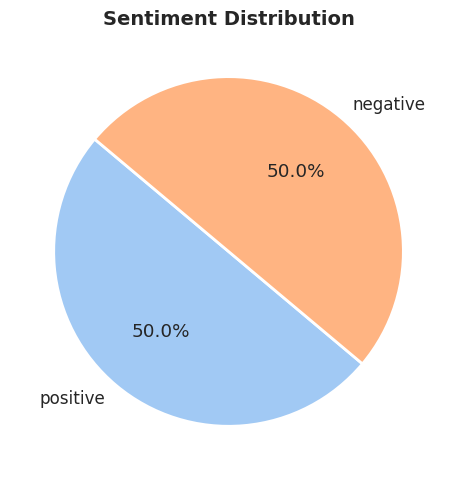

In [5]:
df['sentiment'].value_counts()

sns.set_theme(style="white", font_scale=1.1)

sentiment_counts = df['sentiment'].value_counts()

colors = sns.color_palette("pastel")

plt.figure(figsize=(6.5, 5))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

plt.title("Sentiment Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
df['review_length'] = df['review'].apply(len)
df.groupby('sentiment')['review_length'].mean()

sentiment
negative    1294.06436
positive    1324.79768
Name: review_length, dtype: float64

/tmp/ipykernel_24/1918303964.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


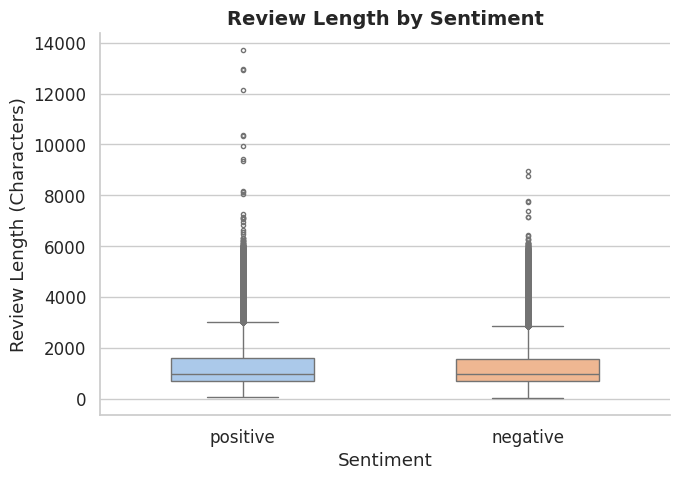

In [7]:
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(7, 5))

sns.boxplot(
    x='sentiment',
    y='review_length',
    data=df,
    palette='pastel',
    width=0.5,
    fliersize=3
)

plt.title("Review Length by Sentiment", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment")
plt.ylabel("Review Length (Characters)")

sns.despine()
plt.tight_layout()
plt.show()

In [8]:
print("Positive review example:")
print(df[df['sentiment'] == 'positive']['review'].iloc[0])

print("_"*150)

print("\nNegative review example:")
print(df[df['sentiment'] == 'negative']['review'].iloc[0])

Positive review example:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of t

# Text Preprocessing

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Text Preprocessing

In this step, the text data is cleaned and prepared for feature extraction.
The preprocessing pipeline includes:
- Converting text to lowercase
- Removing punctuation and non-alphabetic characters
- Tokenizing the text into words
- Removing common English stopwords

The cleaned text is then used for feature extraction and model training.


In [10]:
df.head()

,review,sentiment,review_length,clean_review
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,926,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,748,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter matteis love time money visually stunni...


# Feature Extraction

In [11]:
vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2), 
    min_df=4,
    max_df=0.85,
    sublinear_tf=True
)

X = vectorizer.fit_transform(df['clean_review'])

y = df['sentiment'].map({'positive': 1, 'negative': 0})

# Model Training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=3000,
        C=3.0,
        solver='liblinear',
        class_weight='balanced'
    ),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(C=2.0,
        class_weight='balanced'),
    "SGD Classifier": SGDClassifier(
        loss='log_loss',
        alpha=5e-5,
        max_iter=2000,
        random_state=42
    ),
    "Passive Aggressive": PassiveAggressiveClassifier(
        max_iter=1000,
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
}


In [14]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8992,0.892808,0.909109,0.900885
3,SGD Classifier,0.8952,0.886350,0.908514,0.897295
2,Support Vector Machine,0.8897,0.886792,0.895416,0.891083
1,Naive Bayes,0.8723,0.866810,0.882119,0.874398
4,Passive Aggressive,0.8646,0.863341,0.868823,0.866073
6,Random Forest,0.8548,0.858056,0.852947,0.855494
5,Decision Tree,0.7229,0.729091,0.716214,0.722595


# Deep Learning Approach: BERT-Based Sentiment Analysis


In [15]:
bert_df = df[['review', 'sentiment']].copy()
bert_df['label'] = bert_df['sentiment'].map({'negative': 0, 'positive': 1})
bert_df = bert_df[['review', 'label']]

In [16]:
train_df, test_df = train_test_split(
    bert_df, test_size=0.2, random_state=42
)

In [17]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["review"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=16,
    num_train_epochs=3,             
    weight_decay=0.01,
    logging_steps=200,
    load_best_model_at_end=True,
    report_to="none"
)


In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.223700,0.230995,0.914300,0.911895
2,0.157300,0.272888,0.921700,0.924978
3,0.074700,0.322316,0.927000,0.927694


TrainOutput(global_step=7500, training_loss=0.15958438784281412, metrics={'train_runtime': 3084.7917, 'train_samples_per_second': 38.901, 'train_steps_per_second': 2.431, 'total_flos': 1.57866633216e+16, 'train_loss': 0.15958438784281412, 'epoch': 3.0})

In [24]:
bert_results = trainer.evaluate()
bert_results

{'eval_loss': 0.23099473118782043,
 'eval_accuracy': 0.9143,
 'eval_f1': 0.9118947260203557,
 'eval_runtime': 69.7222,
 'eval_samples_per_second': 143.426,
 'eval_steps_per_second': 8.964,
 'epoch': 3.0}

In [25]:
results_df = results_df.copy()

results_df.loc[len(results_df)] = [
    "DistilBERT",
    bert_results["eval_accuracy"],
    None,
    None,
    bert_results["eval_f1"]
]

results_df


/tmp/ipykernel_24/4144172425.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df.loc[len(results_df)] = [


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8992,0.892808,0.909109,0.900885
3,SGD Classifier,0.8952,0.886350,0.908514,0.897295
2,Support Vector Machine,0.8897,0.886792,0.895416,0.891083
1,Naive Bayes,0.8723,0.866810,0.882119,0.874398
4,Passive Aggressive,0.8646,0.863341,0.868823,0.866073
6,Random Forest,0.8548,0.858056,0.852947,0.855494
5,Decision Tree,0.7229,0.729091,0.716214,0.722595
7,DistilBERT,0.9143,NaN,NaN,0.911895


In [26]:
real_reviews = [
    "This movie was absolutely amazing, I loved every moment of it.",
    "The plot was boring and the acting was terrible.",
    "It started slow but became really emotional and powerful.",
    "I regret watching this movie, it was a complete waste of time."
]

In [27]:
real_inputs = tokenizer(
    real_reviews,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
real_inputs = tokenizer(
    real_reviews,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

real_inputs = {k: v.to(device) for k, v in real_inputs.items()}


In [30]:
model.eval()
with torch.no_grad():
    outputs = model(**real_inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

In [31]:
label_map = {0: "Negative", 1: "Positive"}
pred_labels = [label_map[p.item()] for p in predictions]

In [32]:
for review, label in zip(real_reviews, pred_labels):
    print("Review:")
    print(review)
    print("Predicted Sentiment:", label)
    print("-" * 70)

Review:
This movie was absolutely amazing, I loved every moment of it.
Predicted Sentiment: Positive
----------------------------------------------------------------------
Review:
The plot was boring and the acting was terrible.
Predicted Sentiment: Negative
----------------------------------------------------------------------
Review:
It started slow but became really emotional and powerful.
Predicted Sentiment: Positive
----------------------------------------------------------------------
Review:
I regret watching this movie, it was a complete waste of time.
Predicted Sentiment: Negative
----------------------------------------------------------------------


In [33]:
probs = torch.softmax(outputs.logits, dim=1)

for review, prob in zip(real_reviews, probs):
    print(review)
    print("Positive confidence:", prob[1].item())
    print("Negative confidence:", prob[0].item())
    print("-" * 70)


This movie was absolutely amazing, I loved every moment of it.
Positive confidence: 0.9965235590934753
Negative confidence: 0.0034763801377266645
----------------------------------------------------------------------
The plot was boring and the acting was terrible.
Positive confidence: 0.0033275759778916836
Negative confidence: 0.9966723918914795
----------------------------------------------------------------------
It started slow but became really emotional and powerful.
Positive confidence: 0.9964756369590759
Negative confidence: 0.0035244047176092863
----------------------------------------------------------------------
I regret watching this movie, it was a complete waste of time.
Positive confidence: 0.0034265934955328703
Negative confidence: 0.9965734481811523
----------------------------------------------------------------------


### Real-World Evaluation

The trained BERT model was tested on real-world movie reviews to assess
its ability to generalize beyond the benchmark dataset.
The predictions demonstrate reasonable sentiment understanding
on unseen and naturally written text.
